In [0]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DataType, DecimalType, DateType, DoubleType
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from pyspark.sql import SparkSession

#create session
spark = SparkSession.builder.appName("Soccer Data Analysis").getOrCreate()

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
rankings_intl_df = spark.read.format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_global_rankings_intl.csv")
rankings_df = spark.read.format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_global_rankings.csv")
match_analysis = spark.read.format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_matches_latest.csv")
old_match_analysis = spark.read.format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_matches.csv")

In [0]:
match_analysis.show(5)

+------+----------+---------+--------------------+--------------------+-----------------+-----+-----+------+------+-------+-----------+-----------+-----------+-----------+------+------+----+----+-----+-----+----------+----------+
|season|      date|league_id|              league|               team1|            team2| spi1| spi2| prob1| prob2|probtie|proj_score1|proj_score2|importance1|importance2|score1|score2| xg1| xg2|nsxg1|nsxg2|adj_score1|adj_score2|
+------+----------+---------+--------------------+--------------------+-----------------+-----+-----+------+------+-------+-----------+-----------+-----------+-----------+------+------+----+----+-----+-----+----------+----------+
|  2019|2019-03-01|     1979|Chinese Super League|     Shandong Luneng|    Guizhou Renhe|48.22|37.83|0.5755| 0.174| 0.2505|       1.75|       0.84|       45.9|       22.1|     1|     0|1.39|0.26| 2.05| 0.54|      1.05|       0.0|
|  2019|2019-03-01|     1979|Chinese Super League|  Shanghai Greenland|    Shang

In [0]:
rankings_schema = StructType([
    StructField("rank", IntegerType(), True),
    StructField("prev_rank", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("league", StringType(), True),
    StructField("off", DecimalType(), True),
    StructField("def", DecimalType(), True),
    StructField("spi", DecimalType(), True)
])

spi_matches_schema = StructType([
    StructField("season", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("league_id", IntegerType(), True),
    StructField("league", StringType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("spi1", DecimalType(), True),
    StructField("spi2", DecimalType(), True),
    StructField("prob1", DecimalType(), True),
    StructField("prob2", DecimalType(), True),
    StructField("probtie", DecimalType(), True),
    StructField("proj_score1", DecimalType(), True),
    StructField("proj_score2", DecimalType(), True),
    StructField("importance1", DecimalType(), True),
    StructField("importance2", DecimalType(), True),
    StructField("score1", IntegerType(), True),
    StructField("score2", IntegerType(), True),
    StructField("xg1", DecimalType(), True),
    StructField("xg2", DecimalType(), True),
    StructField("nsxg1", DecimalType(), True),
    StructField("nsxg2", DecimalType(), True),
    StructField("adj_score1", DecimalType(), True),
    StructField("adj_score2", DecimalType(), True)
])

In [0]:
rankings_intl_df = spark.read.schema(rankings_schema).format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_global_rankings_intl.csv")
rankings_df = spark.read.schema(rankings_schema).format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_global_rankings.csv")
match_analysis_df = spark.read.schema(spi_matches_schema).format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_matches_latest.csv")
old_match_analysis_df = spark.read.schema(spi_matches_schema).format("csv").option("header", "true").load("s3://soccer-data-analysis-project/spi_matches.csv")

In [0]:
match_analysis_df.show(5)

+------+----------+---------+--------------------+--------------------+-----------------+----+----+-----+-----+-------+-----------+-----------+-----------+-----------+------+------+---+---+-----+-----+----------+----------+
|season|      date|league_id|              league|               team1|            team2|spi1|spi2|prob1|prob2|probtie|proj_score1|proj_score2|importance1|importance2|score1|score2|xg1|xg2|nsxg1|nsxg2|adj_score1|adj_score2|
+------+----------+---------+--------------------+--------------------+-----------------+----+----+-----+-----+-------+-----------+-----------+-----------+-----------+------+------+---+---+-----+-----+----------+----------+
|  2019|2019-03-01|     1979|Chinese Super League|     Shandong Luneng|    Guizhou Renhe|  48|  38|    1|    0|      0|          2|          1|         46|         22|     1|     0|  1|  0|    2|    1|         1|         0|
|  2019|2019-03-01|     1979|Chinese Super League|  Shanghai Greenland|    Shanghai SIPG|  40|  60|    0

In [0]:
# Count missing values
match_analysis_df.select([count(when(col(c).isNull(), c)).alias(c) for c in match_analysis_df.columns]).show()

# Drop rows with null values in critical columns
match_analysis_df = match_analysis_df.dropna(subset=["team1", "team2", "date", "score1", "score2"])


+------+----+---------+------+-----+-----+----+----+-----+-----+-------+-----------+-----------+-----------+-----------+------+------+----+----+-----+-----+----------+----------+
|season|date|league_id|league|team1|team2|spi1|spi2|prob1|prob2|probtie|proj_score1|proj_score2|importance1|importance2|score1|score2| xg1| xg2|nsxg1|nsxg2|adj_score1|adj_score2|
+------+----+---------+------+-----+-----+----+----+-----+-----+-------+-----------+-----------+-----------+-----------+------+------+----+----+-----+-----+----------+----------+
|     0|   0|        0|     0|    0|    0|   0|   0|    0|    0|      0|          0|          0|       1401|       1401|  1400|  1400|6045|6045| 6045| 6045|      6045|      6045|
+------+----+---------+------+-----+-----+----+----+-----+-----+-------+-----------+-----------+-----------+-----------+------+------+----+----+-----+-----+----------+----------+



In [0]:
# Create New Columns
match_analysis_df = match_analysis_df.withColumn("goal_difference", col("score1") - col("score2")) \
                                 .withColumn("match_result", when(col("score1") > col("score2"), "home_win")
                                                      .when(col("score1") < col("score2"), "away_win")
                                                      .otherwise("draw"))


In [0]:
# Calculate total goals scored by each team
total_goals_df = match_analysis_df.select("team1", "score1", "team2", "score2") \
    .withColumn("total_goals", match_analysis_df["score1"] + match_analysis_df["score2"]) \
    .groupBy("team1") \
    .agg({"total_goals": "sum"}) \
    .withColumnRenamed("sum(total_goals)", "total_goals_scored")

total_goals_df.show()

+------------------+------------------+
|             team1|total_goals_scored|
+------------------+------------------+
|           Antwerp|                57|
|           Palermo|                42|
|             Mainz|                56|
|      Salford City|                52|
|               RKC|                60|
| Slovan Bratislava|                13|
|   Shonan Bellmare|                28|
|1. FC Union Berlin|                54|
|        Dundee Utd|                58|
|          Espanyol|                62|
|            Málaga|                37|
|        Sagan Tosu|                23|
|       Tigres UANL|                49|
|     Karlsruher SC|                57|
|   Cheltenham Town|                52|
|Argentinos Juniors|                27|
|             Nimes|                50|
|                AZ|                75|
|       SC Freiburg|                50|
|         FC Luzern|                50|
+------------------+------------------+
only showing top 20 rows



In [0]:
# Register the DataFrames as temporary views
match_analysis_df.createOrReplaceTempView("spi_matches")
rankings_df.createOrReplaceTempView("spi_global_rankings")

In [0]:
# Example SQL query to get total matches and average goals scored by each team
average_goals_query = """
SELECT team1, COUNT(*) as total_matches, AVG(score1 + score2) as avg_goals_scored
FROM spi_matches
GROUP BY team1
ORDER BY avg_goals_scored DESC
"""
average_goals_df = spark.sql(average_goals_query)
average_goals_df.show()

+--------------------+-------------+------------------+
|               team1|total_matches|  avg_goals_scored|
+--------------------+-------------+------------------+
|           Viking FK|            5|               5.2|
|      Viktoria Plzen|            3| 4.666666666666667|
|           BK Hacken|            7| 4.571428571428571|
|       Maccabi Haifa|            3| 4.333333333333333|
|    SV Zulte Waregem|           17| 4.294117647058823|
|        Guangzhou RF|           15| 4.266666666666667|
|      Melbourne City|           15|               4.2|
|Brighton & Hove A...|           11| 4.090909090909091|
|        KVC Westerlo|           20|              4.05|
|          Lillestrom|            5|               4.0|
|     Manchester City|           26|               4.0|
|    Fatih Karagümrük|           18|3.9444444444444446|
| Zenit St Petersburg|           15| 3.933333333333333|
|          Fenerbahce|           22| 3.909090909090909|
|       Columbus Crew|            9| 3.888888888

In [0]:
#Team Performance Over Seasons
man_city_performance = """
SELECT season, 
       team1 AS team,
       SUM(CASE WHEN match_result = 'home_win' THEN 1 ELSE 0 END) AS home_wins,
       SUM(CASE WHEN match_result = 'away_win' THEN 1 ELSE 0 END) AS away_wins,
       SUM(CASE WHEN match_result = 'draw' THEN 1 ELSE 0 END) AS draws
FROM spi_matches
WHERE team1 = 'Manchester City'
GROUP BY season, team1
ORDER BY season
"""
man_city_df = spark.sql(man_city_performance)
man_city_df.show()

+------+---------------+---------+---------+-----+
|season|           team|home_wins|away_wins|draws|
+------+---------------+---------+---------+-----+
|  2022|Manchester City|       24|        1|    1|
+------+---------------+---------+---------+-----+



In [0]:
# Average Goals Conceded per Team
average_goals_conceded = """
SELECT team2 AS team, 
       AVG(score1) AS avg_goals_conceded
FROM spi_matches
GROUP BY team2
ORDER BY avg_goals_conceded DESC
"""
average_goals_df = spark.sql(average_goals_conceded)
average_goals_df.show()

+--------------------+------------------+
|                team|avg_goals_conceded|
+--------------------+------------------+
|      Viktoria Plzen| 4.666666666666667|
|     Hamarkamaratene|               4.0|
|        Degerfors IF|               4.0|
|       Maccabi Haifa|               4.0|
|    Steaua Bucuresti|3.3333333333333335|
|             Stabaek|              3.25|
|           FC Khimki|               2.8|
|Brighton & Hove A...| 2.727272727272727|
|              Troyes|2.6842105263157894|
|   Red Star Belgrade|2.6666666666666665|
|        Guangzhou RF|2.6666666666666665|
|        HJK Helsinki|2.6666666666666665|
|           Excelsior|2.6470588235294117|
|    Shakhtar Donetsk|               2.6|
|            Coritiba|               2.6|
|           Hatayspor|2.5555555555555554|
|         KV Oostende|2.5294117647058822|
|   Chicago Red Stars|               2.5|
|     América Mineiro|               2.5|
|               Eupen|2.4705882352941178|
+--------------------+------------

In [0]:
total_goals_df = spark.sql("""
    SELECT team1 AS team, SUM(score1) AS total_goals_scored
    FROM spi_matches
    GROUP BY team1
    ORDER BY total_goals_scored DESC
""")
total_goals_df.show()


+-------------------+------------------+
|               team|total_goals_scored|
+-------------------+------------------+
|    Manchester City|                85|
|      Bayern Munich|                65|
|                PSV|                64|
|       Ipswich Town|                60|
|  Borussia Dortmund|                60|
|            Benfica|                60|
|             Celtic|                59|
|            Arsenal|                59|
|         Fenerbahce|                58|
|        Real Madrid|                57|
|Paris Saint-Germain|                55|
|        Aston Villa|                55|
|             Napoli|                55|
|          Feyenoord|                54|
|          Liverpool|                54|
|         Young Boys|                54|
|               Ajax|                52|
|            Rangers|                52|
|       Stade Rennes|                50|
|           AC Milan|                50|
+-------------------+------------------+
only showing top

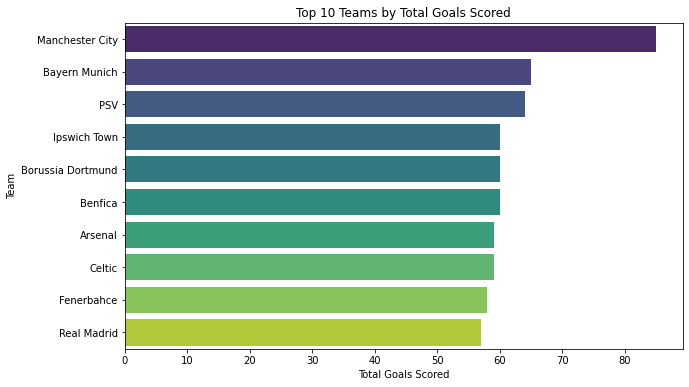

In [0]:
total_goals_pandas = total_goals_df.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='total_goals_scored', y='team', data=total_goals_pandas.head(10), palette='viridis')
plt.title('Top 10 Teams by Total Goals Scored')
plt.xlabel('Total Goals Scored')
plt.ylabel('Team')
plt.show()


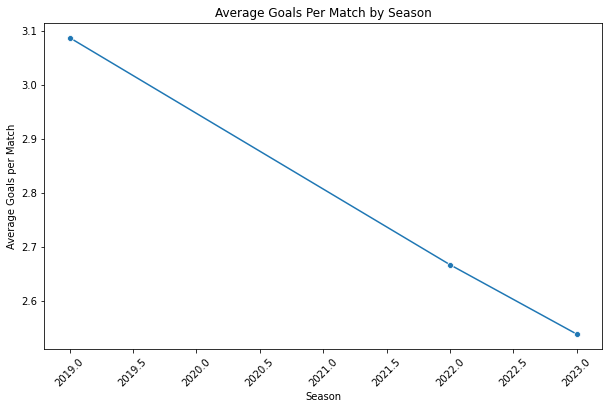

In [0]:
avg_goals_df = spark.sql("""
    SELECT season, AVG(score1 + score2) AS avg_goals_per_match
    FROM spi_matches
    GROUP BY season
    ORDER BY season
""")
avg_goals_pandas = avg_goals_df.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(x='season', y='avg_goals_per_match', data=avg_goals_pandas, marker='o')
plt.title('Average Goals Per Match by Season')
plt.xlabel('Season')
plt.ylabel('Average Goals per Match')
plt.xticks(rotation=45)
plt.show()


In [0]:
# Group by league to calculate average SPI ratings, probabilities, and goals
league_stats_df = match_analysis_df.groupBy("league") \
    .agg(
        {"spi1": "avg", "spi2": "avg", "prob1": "avg", "prob2": "avg", 
         "score1": "avg", "score2": "avg", "proj_score1": "avg", "proj_score2": "avg"}
    ) \
    .withColumnRenamed("avg(spi1)", "avg_spi_home") \
    .withColumnRenamed("avg(spi2)", "avg_spi_away") \
    .withColumnRenamed("avg(prob1)", "avg_prob_home_win") \
    .withColumnRenamed("avg(prob2)", "avg_prob_away_win") \
    .withColumnRenamed("avg(score1)", "avg_score_home") \
    .withColumnRenamed("avg(score2)", "avg_score_away") \
    .withColumnRenamed("avg(proj_score1)", "avg_proj_score_home") \
    .withColumnRenamed("avg(proj_score2)", "avg_proj_score_away")

league_stats_df.show()


+--------------------+-----------------+------------+------------------+------------+------------------+-------------------+-----------------+-------------------+
|              league|avg_prob_away_win|avg_spi_home|    avg_score_home|avg_spi_away|    avg_score_away|avg_proj_score_home|avg_prob_home_win|avg_proj_score_away|
+--------------------+-----------------+------------+------------------+------------+------------------+-------------------+-----------------+-------------------+
|Mexican Primera D...|           0.0298|     47.9762|1.5178571428571428|     47.8036| 1.255952380952381|             1.4345|           0.3571|             1.1310|
|       Italy Serie B|           0.0103|     33.3462|1.2897435897435898|     33.1000|1.0384615384615385|             1.3436|           0.2128|             1.0333|
|      French Ligue 1|           0.1211|     61.5500|1.4894736842105263|     61.4211| 1.318421052631579|             1.5184|           0.3447|             1.2158|
|     Portuguese Liga|

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [avg_prob_away_win, avg_spi_home, avg_spi_away, avg_proj_score_home, avg_prob_home_win, avg_proj_score_away] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


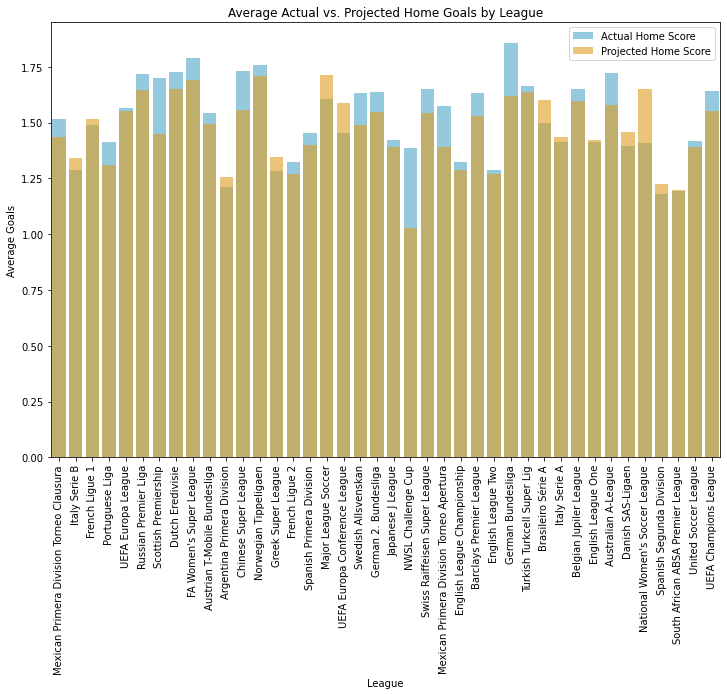

In [0]:
# Convert Spark DataFrame to Pandas for visualization
league_stats_pd = league_stats_df.toPandas()

# Compare average actual and projected goals for each league
plt.figure(figsize=(12, 8))
sns.barplot(x='league', y='avg_score_home', data=league_stats_pd, color='skyblue', label="Actual Home Score")
sns.barplot(x='league', y='avg_proj_score_home', data=league_stats_pd, color='orange', alpha=0.6, label="Projected Home Score")
plt.xticks(rotation=90)
plt.title("Average Actual vs. Projected Home Goals by League")
plt.xlabel("League")
plt.ylabel("Average Goals")
plt.legend()
plt.show()


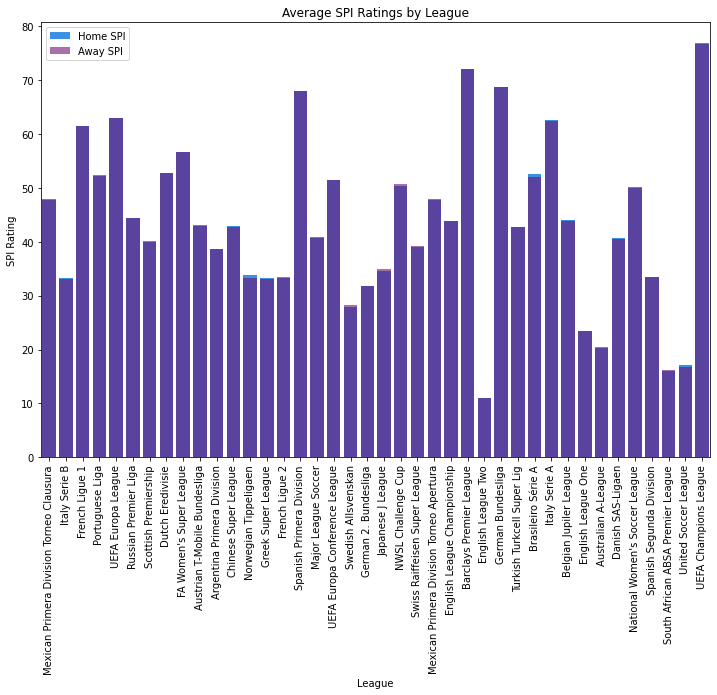

In [0]:
# Calculate average SPI rating by league and plot
plt.figure(figsize=(12, 8))
sns.barplot(x='league', y='avg_spi_home', data=league_stats_pd, color='dodgerblue', label="Home SPI")
sns.barplot(x='league', y='avg_spi_away', data=league_stats_pd, color='purple', alpha=0.6, label="Away SPI")
plt.xticks(rotation=90)
plt.title("Average SPI Ratings by League")
plt.xlabel("League")
plt.ylabel("SPI Rating")
plt.legend()
plt.show()

In [0]:
# Select features and label
features_df = match_analysis_df.select("spi1", "spi2", "importance1", "importance2", "score1", "score2", "match_result")
features_df = features_df.withColumn("label", when(col("match_result") == "home_win", 1).otherwise(0))

# Assemble features into a vector
assembler = VectorAssembler(inputCols=["spi1", "spi2", "importance1", "importance2"], outputCol="features")
final_data = assembler.transform(features_df)


In [0]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

In [0]:
# Train Logistic Regression Model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
# Evaluate Model with BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Predict on test data
predictions = lr_model.transform(test_data)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {test_results.accuracy}")

predictions = test_results.predictions
predictions_pd = predictions.toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='probability', y='label', data=predictions_pd)
plt.title('Predicted Probability of Home Win vs Actual Outcome')
plt.xlabel('Predicted Probability of Home Win')
plt.ylabel('Actual Outcome')
plt.axhline(y=0.5, color='r', linestyle='--')  # Decision boundary
plt.show()

final_data.write.csv("dbfs:/FileStore/output/final_match_data.csv", header=True)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-2842378757181539>:3
      1 # Train Logistic Regression Model
      2 lr = LogisticRegression(featuresCol='features', labelCol='label')
----> 3 lr_model = lr.fit(train_data)
      4 # Evaluate Model with BinaryClassificationEvaluator
      5 from pyspark.ml.evaluation import BinaryClassificationEvaluator

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/spark/python/pyspark/ml/base.py:205, in Estimator.fit(self, dataset, params)
    203         return self.copy(params)._fit(dataset)
    204     else:
--> 205         return self._fit(datase